In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from tqdm import tqdm
import pixellib
from pixellib.semantic import semantic_segmentation
import pandas as pd
%matplotlib inline
%load_ext blackcellmagic

In [4]:
PATH_TO_IMG = "data/3.png"
img = cv2.imread(PATH_TO_IMG)

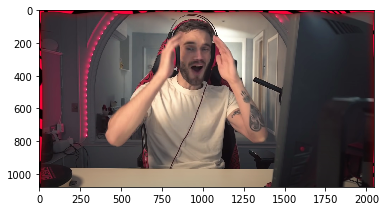

In [5]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
segment_image = semantic_segmentation()
segment_image.load_ade20k_model("deeplabv3_xception65_ade20k.h5")
output, segmap = segment_image.segmentAsAde20k(PATH_TO_IMG, "output.png")

Processed Image saved successfuly in your current working directory.


In [7]:
df = pd.read_csv("objectInfo150.csv")
labels = pd.Series(df.Name.values,index=df.Idx).to_dict()

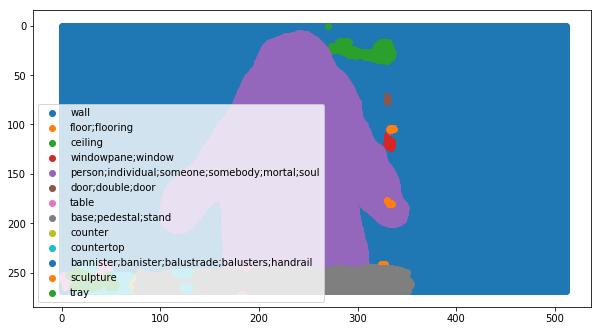

In [8]:
plt.figure(figsize=(10, 8))
cats = np.unique(output)
for v in cats:
    X, Y = np.where(output == v)
    plt.scatter(Y, X) # because image
plt.gca().invert_yaxis()
plt.legend([labels[c] for c in cats])
plt.gca().set_aspect('equal')
plt.show()

# Maximum rectangle

In [9]:
def _last_smaller(x):
    y = [-1 for _ in x]
    stack = [0]
    for i in range(1, len(x)):
        while stack and x[stack[-1]] >= x[i]:
            stack.pop()
        if stack:
            y[i] = stack[-1]
        stack.append(i)
    return y

def _area_under_histogram(hist):
    left = _last_smaller(hist)
    right = _last_smaller(list(reversed(hist)))
    best = 0
    res = -1, -1
    n = len(hist)
    for i in range(n):
        rbound = n-1-right[n-1-i]
        lbound = left[i]
        area = hist[i] * (rbound - lbound - 1)
        if area > best:
            best = area
            res = lbound+1, rbound-1
    return best, res

def max_rectangle(arr):
    n, m = len(arr), len(arr[0])
    hist = [0 for _ in range(m)]
    best = 0
    bounds = -1, -1, -1, -1
    for i in range(n):
        for j in range(m):
            if arr[i][j]:
                hist[j] += 1
            else:
                hist[j] = 0
        area, res = _area_under_histogram(hist)
        if area > best:
            assert area % (res[1] - res[0] + 1) == 0, "Area should be width x height"
            height = area // (res[1] - res[0] + 1)
            best = area
            bounds = i, res[0], height, res[1] - res[0] + 1
    return best, bounds

# Use max rectangle to find ad location

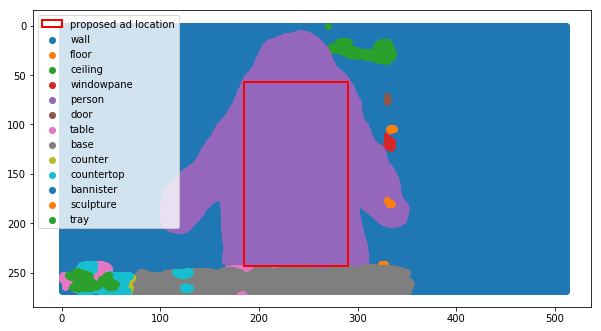

In [17]:
best, bounds = max_rectangle(output == 13)  # person
fig, ax = plt.subplots(1, figsize=(10, 8))
cats = np.unique(output)
for v in cats:
    X, Y = np.where(output == v)
    plt.scatter(Y, X)  # because image

ax.add_patch(
    patches.Rectangle(
        (bounds[1], bounds[0] - bounds[2]),
        bounds[3],
        bounds[2],
        linewidth=2,
        edgecolor="r",
        facecolor="none",
    )
)

plt.gca().invert_yaxis()
plt.gca().set_aspect("equal")
plt.legend(["proposed ad location"] + [labels[c].split(";")[0] for c in cats])
plt.show()

In [15]:
def _translate_dims(x, y, in_shape, out_shape):
    return int(x * out_shape[0] / in_shape[0]), int(y * out_shape[1] / in_shape[1])

# Strategy for people

find the avg color of the rectangle

In [34]:
x, y = _translate_dims(bounds[0] - bounds[2], bounds[1], output.shape, img.shape)
w, h = _translate_dims(bounds[2], bounds[3], output.shape, img.shape)

In [37]:
(x, y, w, h)

(228, 740, 744, 420)

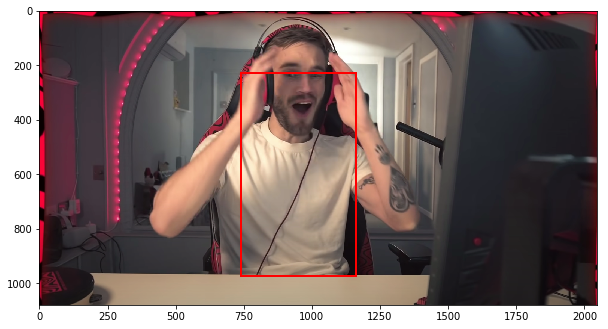

In [67]:
fig, ax = plt.subplots(1, figsize=(10, 8))

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax.add_patch(
    patches.Rectangle((y, x), h, w, linewidth=2, edgecolor="r", facecolor="none")
)

plt.show()

So we need to shrink this rect down to just the shirt.

In [110]:
# avg_color = np.mean(img[x:x+w,y:y+h], axis=(0,1))
avg_color = [125, 150, 170]
std_color = np.std(img[x:x+w,y:y+h], axis=(0,1))

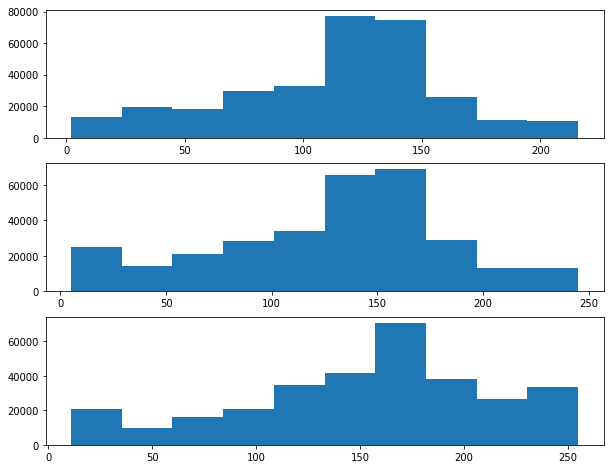

In [112]:
plt.subplots(1, figsize=(10, 8))
plt.subplot(311)
plt.hist(img[x : x + w, y : y + h, 0].flatten())
plt.subplot(312)
plt.hist(img[x : x + w, y : y + h, 1].flatten())
plt.subplot(313)
plt.hist(img[x : x + w, y : y + h, 2].flatten())
plt.show()

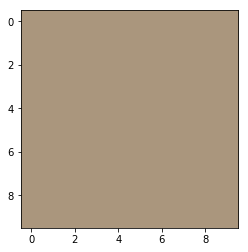

In [111]:
plt.imshow(
    cv2.cvtColor(
        np.array([[np.uint8(avg_color) for _ in range(10)] for _ in range(10)]),
        cv2.COLOR_BGR2RGB,
    )
)

In [95]:
STDS = 1.5
mask = np.uint8(
    np.linalg.norm(img - avg_color, axis=2) < STDS * np.linalg.norm(std_color)
)

In [90]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

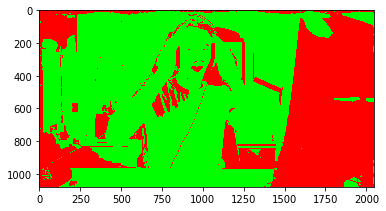

In [96]:
palette = np.array([[255, 0, 0], [0, 255, 0]])
plt.imshow(palette[mask])

Solution: add 20% of width to x and decrease width

# Which objects can we put ads on?

In [11]:
# premium real estate for ads
OBJECTS_FOR_ADS = [
    1,    # wall
    2,    # building
    13,   # person
    21,   # car
    26,   # house
    44,   # signboard
    49,   # skyscraper
    51,   # refrigerator
    145,  # bulletin board
]

# For signboards

iterate over each object type

given an object type mapped to the original image
- find the average color
- find pixels close to the average color
- fill in holes

In [16]:
def find_ad_space(img, output, object_ty):
    mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            ox, oy = _translate_dims(x, y, img.shape, output.shape)
            if output[ox][oy] == object_ty:
                mask[x][y] = 1
    nx, ny = zip(np.where(mask))
    minx = np.min(nx)
    maxx = np.max(nx)
    miny = np.min(ny)
    maxy = np.max(ny)

    mask[minx : maxx + 1, miny : maxy + 1] = 1
    std = np.std(np.stack([mask for _ in range(3)], axis=-1) * img, axis=(0, 1))
    if np.any(std > [11, 11, 11]):
        print("This could be bad.")
        print(std)
        # TODO try to find a smaller bounding box that is good?
    return minx, miny, maxx - minx, maxy - miny

In [13]:
x, y, w, h = find_ad_space(img, output, 44)

ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax.add_patch(
    patches.Rectangle((y, x), h, w, linewidth=2, edgecolor="r", facecolor="none")
)
plt.show()

In [ ]:
plt.subplots(1, figsize=(10, 8))
plt.imshow(cv2.cvtColor(mask * img, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
np.unique(img[np.where(mask[:, :, 0])][:, 0])